In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df_obs = pd.read_csv('/content/drive/MyDrive/colab_data/Dscover 25-1 메인프로젝트/데이터_분석과제_7_기상관측데이터_2401_2503.csv')
df_pred = pd.read_csv('/content/drive/MyDrive/colab_data/Dscover 25-1 메인프로젝트/데이터_분석과제_7_기상예측데이터_2401_2503.csv')
df_fill = pd.read_csv('/content/drive/MyDrive/colab_data/Dscover 25-1 메인프로젝트/공모전_data.csv')

In [3]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 47.9 MB/s eta 0:00:00


In [ ]:
df_fill

,기상관측일시,관측_습도,관측_기온,관측_대기압,예측_일사량,예측_습도,예측_절대습도,예측_기온,예측_대기압,월,일,시
0,2024-01-01 00:00:00,85.23,3.82,764.46793,0.000000,57.061001,0.004000,0.803001,756.447693,1,1,0
1,2024-01-01 01:00:00,86.75,3.76,764.68855,0.000000,58.348000,0.004000,1.141000,756.926086,1,1,1
2,2024-01-01 02:00:00,86.43,3.04,765.05595,0.000000,58.896999,0.004000,1.417000,757.237183,1,1,2
3,2024-01-01 03:00:00,90.60,1.99,765.42151,0.000000,58.438000,0.004000,1.498000,757.490662,1,1,3
4,2024-01-01 04:00:00,92.59,1.25,765.61559,0.000000,58.285999,0.004000,1.172000,757.593994,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
10940,2025-03-31 20:00:00,38.48,9.89,762.69059,0.000000,41.709999,0.004000,6.140000,756.721985,3,31,20
10941,2025-03-31 21:00:00,44.51,8.76,763.16659,0.000000,45.688000,0.004000,4.839000,756.883850,3,31,21
10942,2025-03-31 22:00:00,51.41,7.92,763.54106,0.000000,48.203999,0.004000,4.344000,756.949280,3,31,22
10943,2025-03-31 23:00:00,56.36,6.76,763.63648,0.000000,48.858002,0.004000,3.901999,757.015442,3,31,23


In [4]:
!pip install lightgbm

In [5]:
import warnings
warnings.filterwarnings('ignore')

#LGBM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# 0) 설정 -----------------------------------------------------------------------------
max_lag   = 3
ma_window = 3
n_steps   = 24

obs_cols  = ['관측_기온','관측_습도','관측_대기압']
time_cols = ['hour_sin','hour_cos','day_sin','day_cos','month_sin','month_cos','is_2025']

# 1) 데이터 준비 -----------------------------------------------------------------------
df = df_fill.copy()
df['기상관측일시'] = pd.to_datetime(df['기상관측일시'])
df = df.sort_values('기상관측일시').set_index('기상관측일시')

# 시간 순환 인코딩 + 2025 플래그
df['hour_sin']  = np.sin(2*np.pi * df['시']/24)
df['hour_cos']  = np.cos(2*np.pi * df['시']/24)
df['day_sin']   = np.sin(2*np.pi * df['일']/31)
df['day_cos']   = np.cos(2*np.pi * df['일']/31)
df['month_sin'] = np.sin(2*np.pi * df['월']/12)
df['month_cos'] = np.cos(2*np.pi * df['월']/12)
df['is_2025']   = (df.index.year == 2025).astype(int)
df.drop(columns=['시','일','월'], inplace=True)

# 2) lag & MA 피처 생성
for c in obs_cols:
    for lag in range(1, max_lag+1):
        df[f'{c}_lag{lag}'] = df[c].shift(lag)
    df[f'{c}_ma{ma_window}'] = df[c].shift(1).rolling(ma_window, min_periods=1).mean()
df.dropna(inplace=True)

# 3) train/val 분리 (2025-03-01 이후를 val)
train = df[:'2025-02-28 23:00']
val   = df['2025-03-01':'2025-03-31 23:00']

X_train = train.drop(obs_cols, axis=1)
y_train = train[obs_cols]
X_val   = val.drop(obs_cols, axis=1)
y_val   = val[obs_cols]

# 4) LightGBM baseline 학습 & 예측
lgb = LGBMRegressor(
    objective='regression',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=8,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)
model_lgb = MultiOutputRegressor(lgb)
model_lgb.fit(X_train, y_train)

y_train_pred = model_lgb.predict(X_train)
y_val_pred   = model_lgb.predict(X_val)

# 5) 원예측 평가 (optional)
weights = np.array([0.5, 0.3, 0.2])

print("=== FINAL Performance ===")
rmse_raw, mae_raw = [], []
for i, col in enumerate(obs_cols):
    # raw
    r_raw = np.sqrt(mean_squared_error(y_val[col], y_val_pred[:, i]))
    m_raw = mean_absolute_error(   y_val[col], y_val_pred[:, i])
    rmse_raw.append(r_raw); mae_raw.append(m_raw)

    print(f"{col:8s} ▶ Raw      RMSE: {r_raw:.3f}, MAE: {m_raw:.3f}")
# 가중 합산 지표
sRMSE_raw = (weights * np.array(rmse_raw)).sum()
sMAE_raw  = (weights * np.array(mae_raw )).sum()
sAError_raw = (sRMSE_raw + sMAE_raw) / 2
print(f"RAW   ▶ sRMSE: {sRMSE_raw:.4f}, sMAE: {sMAE_raw:.4f}, sAError: {sAError_raw:.4f}")

=== FINAL Performance ===
관측_기온    ▶ Raw      RMSE: 0.639, MAE: 0.456
관측_습도    ▶ Raw      RMSE: 3.632, MAE: 2.430
관측_대기압   ▶ Raw      RMSE: 0.325, MAE: 0.237
RAW   ▶ sRMSE: 1.4744, sMAE: 1.0046, sAError: 1.2395


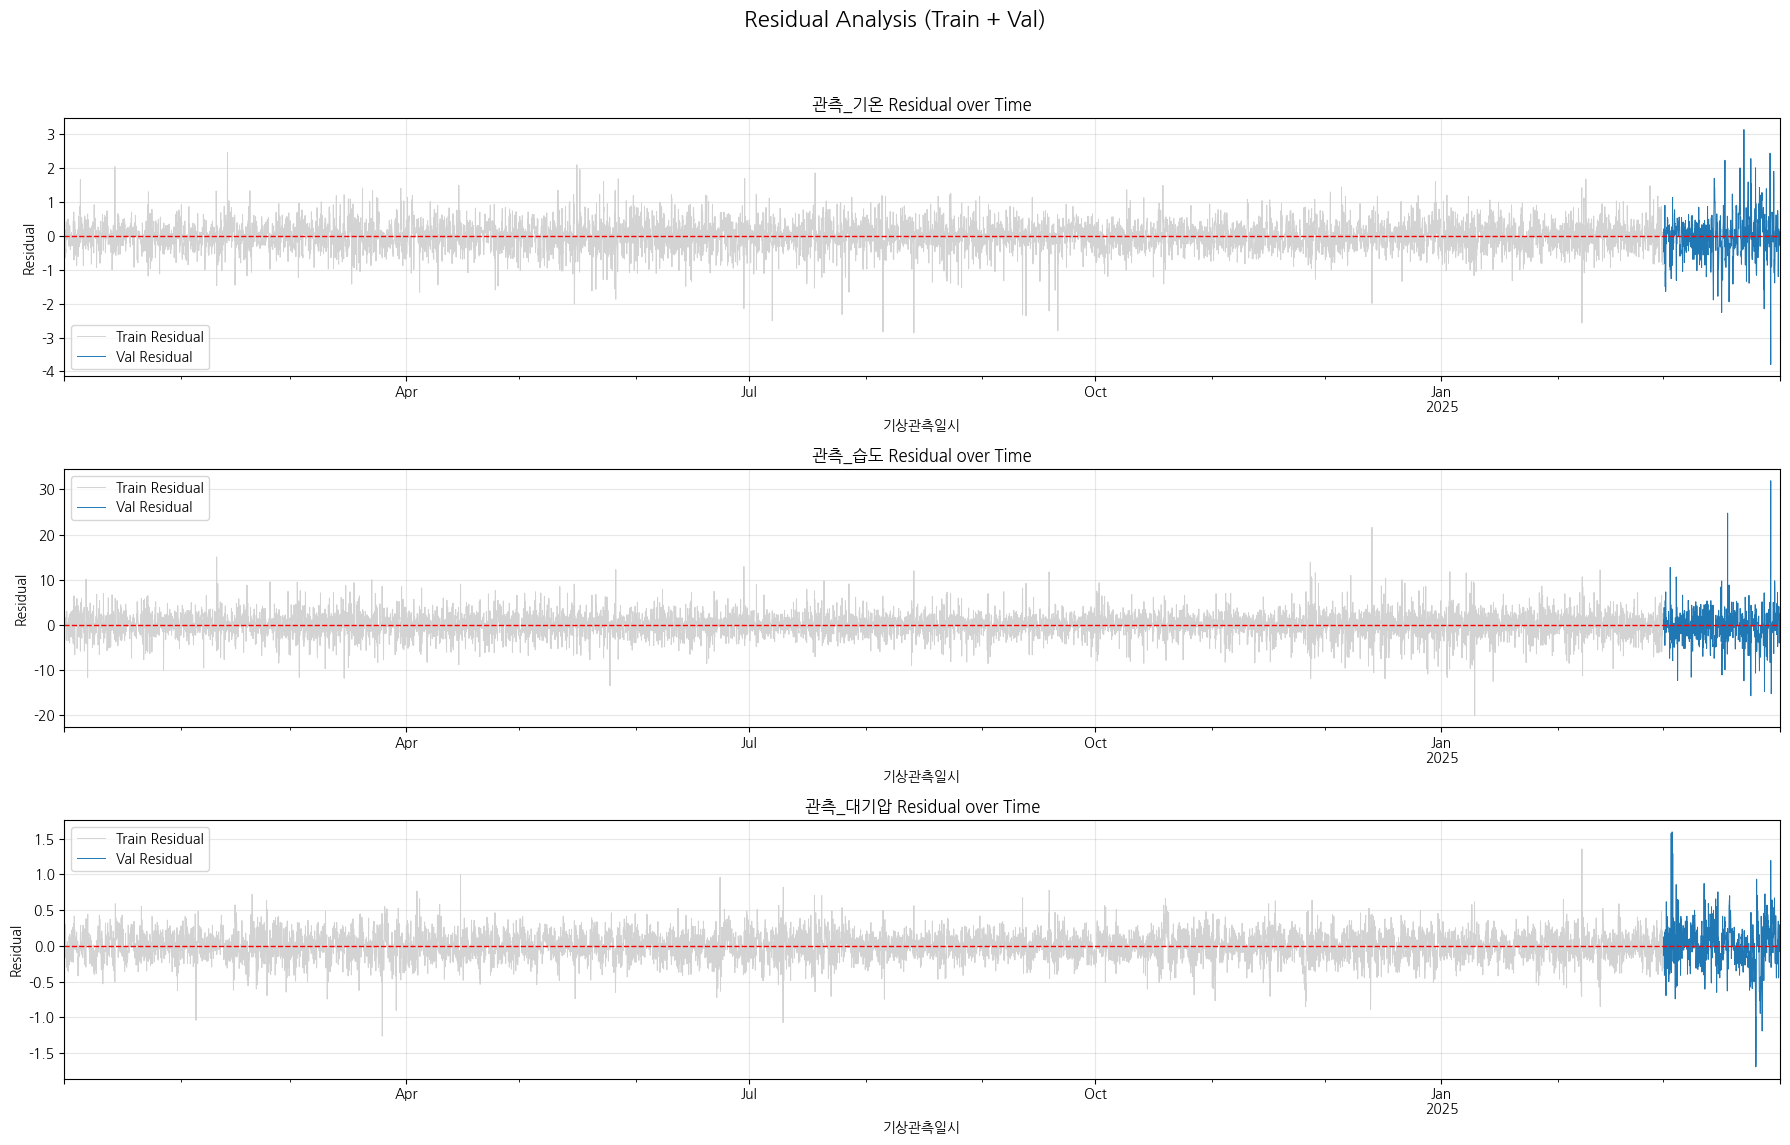

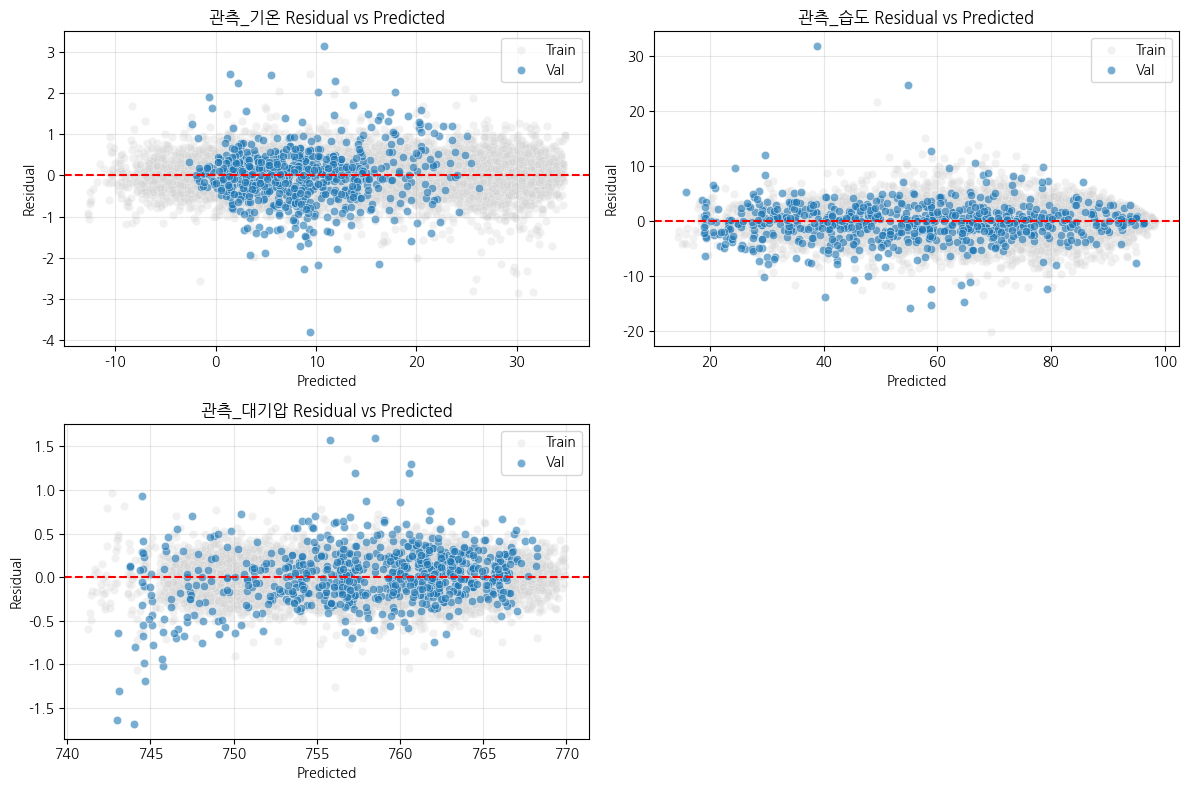

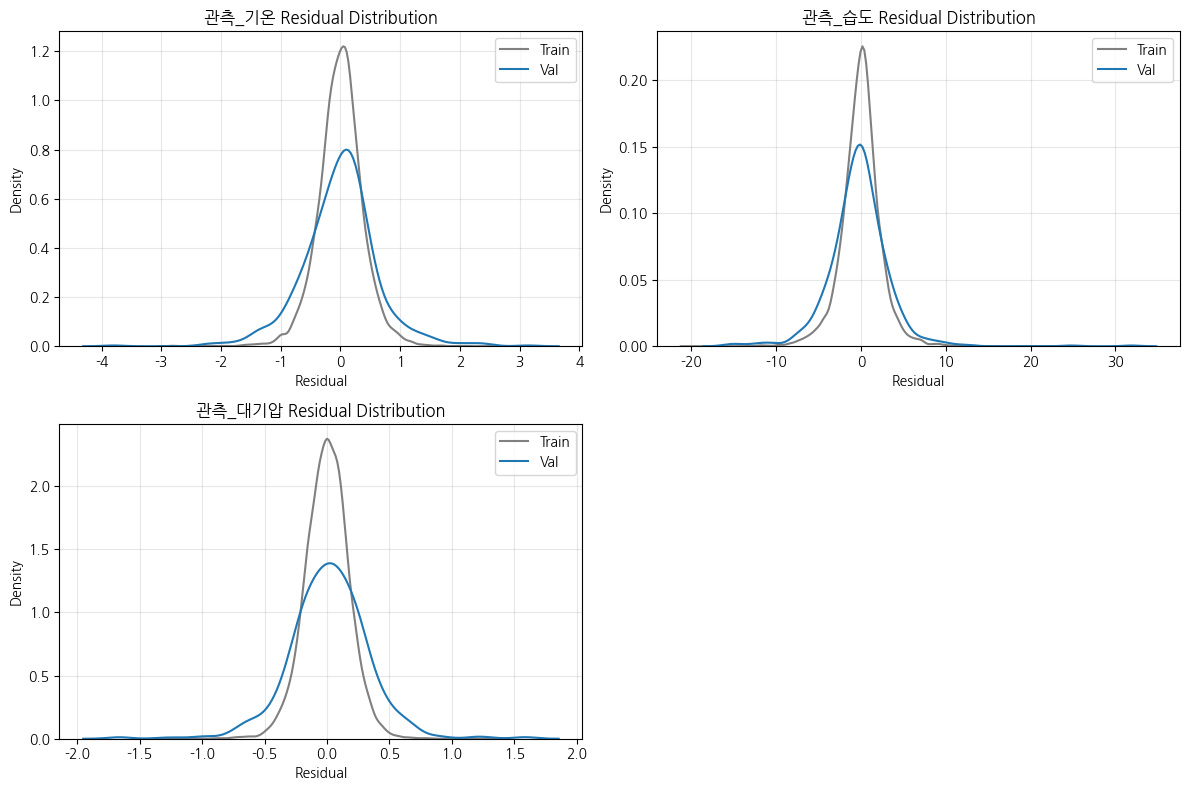

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) train/val residual 계산
# 이미 model_lgb가 학습된 상태라고 가정
y_train_pred = model_lgb.predict(X_train)
y_val_pred   = model_lgb.predict(X_val)

res_train = y_train.values - y_train_pred   # shape=(n_train, 3)
res_val   = y_val.values   - y_val_pred     # shape=(n_val,   3)

resid_train_df = pd.DataFrame(res_train, index=y_train.index, columns=obs_cols)
resid_val_df   = pd.DataFrame(res_val,   index=y_val.index,   columns=obs_cols)

# 2) 시각화
plt.figure(figsize=(18, 12))
plt.suptitle("Residual Analysis (Train + Val)", fontsize=16)

# 2-1) 시계열상 잔차 변화 (train: lightgray, val: blue)
for i, col in enumerate(obs_cols):
    ax = plt.subplot(3, 1, i+1)
    resid_train_df[col].plot(ax=ax, color='lightgray', lw=0.7, label='Train Residual')
    resid_val_df[col].plot(ax=ax,   color='tab:blue',   lw=0.7, label='Val Residual')
    ax.axhline(0, color='red', ls='--', lw=1)
    ax.set_title(f"{col} Residual over Time")
    ax.set_ylabel("Residual")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 2-2) (optional) 예측값 vs 잔차 산점도에 train/val 구분까지 넣고 싶다면
plt.figure(figsize=(12, 8))
for i, col in enumerate(obs_cols):
    ax = plt.subplot(2, 2, i+1)
    sns.scatterplot(x=y_train_pred[:, i], y=resid_train_df[col],
                    alpha=0.3, color='lightgray', label='Train', ax=ax)
    sns.scatterplot(x=y_val_pred[:,   i], y=resid_val_df[col],
                    alpha=0.6, color='tab:blue',   label='Val',   ax=ax)
    ax.axhline(0, color='red', ls='--')
    ax.set_title(f"{col} Residual vs Predicted")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residual")
    ax.legend()
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2-3) (optional) 잔차 분포 비교
plt.figure(figsize=(12, 8))
for i, col in enumerate(obs_cols):
    ax = plt.subplot(2, 2, i+1)
    sns.kdeplot(resid_train_df[col], color='gray', label='Train', ax=ax)
    sns.kdeplot(resid_val_df[col],   color='tab:blue', label='Val',   ax=ax)
    ax.set_title(f"{col} Residual Distribution")
    ax.set_xlabel("Residual")
    ax.legend()
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#XGBoost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 0) 설정 ---------------------------------------------------------------
max_lag = 3            # lag 최대 시차
ma_window = 3          # 이동평균 window
observed_features = ['관측_기온', '관측_습도', '관측_대기압']
target_cols       = observed_features.copy()

# 1) 데이터 준비 -------------------------------------------------------
df = df_fill.copy()
df['기상관측일시'] = pd.to_datetime(df['기상관측일시'])
df = df.sort_values('기상관측일시').set_index('기상관측일시')

# 시간 주기성 인코딩
df['hour_sin']  = np.sin(2 * np.pi * df['시'] / 24)
df['hour_cos']  = np.cos(2 * np.pi * df['시'] / 24)
df['day_sin']   = np.sin(2 * np.pi * df['일'] / 31)
df['day_cos']   = np.cos(2 * np.pi * df['일'] / 31)
df['month_sin'] = np.sin(2 * np.pi * df['월'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['월'] / 12)

# 2025년 여부 플래그
df['is_2025'] = (df.index.year == 2025).astype(int)

# 순환 변수용 원본 컬럼 제거
df = df.drop(columns=['시', '일', '월'])
# 3) lag & MA 피처 생성 (train/val 구분 전)
for col in observed_features:
    for lag in range(1, max_lag+1):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)
    df[f'{col}_ma{ma_window}'] = (
        df[col].shift(1)
               .rolling(ma_window, min_periods=1)
               .mean()
    )

# 4) NaN 제거 (전체 데이터 첫 max_lag 행만 빠짐)
df = df.dropna()

# 5) train/val 분리
train = df[:'2025-02-28 20:00']
val   = df['2025-03-01': '2025-03-31 23:00']

X_train, y_train = train.drop(observed_features, axis=1), train[observed_features]
X_val,   y_val   = val.drop(observed_features, axis=1),   val[observed_features]

# 5) LightGBM 모델 학습 ------------------------------------------------
xgb = XGBRegressor(
    objective     = 'reg:squarederror',
    n_estimators  = 200,
    learning_rate = 0.05,
    max_depth     = 8,
    random_state  = 42,
    n_jobs        = -1
)
model_xgb = MultiOutputRegressor(xgb)
model_xgb.fit(X_train, y_train)

# 6) 예측 & 평가 -------------------------------------------------------
y_pred = model_xgb.predict(X_val)

# 개별 RMSE/MAE
rmse_list, mae_list = [], []
for i, col in enumerate(target_cols):
    rmse = np.sqrt(mean_squared_error(y_val[col], y_pred[:, i]))
    mae  = mean_absolute_error(y_val[col], y_pred[:, i])
    rmse_list.append(rmse)
    mae_list.append(mae)
    print(f"{col:8s} ▶ RMSE: {rmse:.3f}, MAE: {mae:.3f}")

# sRMSE, sMAE, sAError 계산 (가중치 예시: [기온, 습도, 대기압])
weights = np.array([0.5, 0.3, 0.2])
sRMSE   = (weights * np.array(rmse_list)).sum()
sMAE    = (weights * np.array(mae_list)).sum()
sAError = (sRMSE + sMAE) / 2

print(f"sRMSE   = {sRMSE:.4f}")
print(f"sMAE    = {sMAE:.4f}")
print(f"sAError = {sAError:.4f}")


관측_기온    ▶ RMSE: 0.625, MAE: 0.445
관측_습도    ▶ RMSE: 3.619, MAE: 2.481
관측_대기압   ▶ RMSE: 0.322, MAE: 0.232
sRMSE   = 1.4626
sMAE    = 1.0132
sAError = 1.2379


#트리 모델로 잔차 학습

In [ ]:
# 7) 잔차 학습 (Residual Learning) -----------------------------------------
# 7-1) train 세트에서 잔차 계산
residual_train = y_train.values - model_xgb.predict(X_train)

# 7-2) 잔차용 LightGBM 모델 정의
res_lgbm = LGBMRegressor(
    objective     = 'regression',
    n_estimators  = 100,     # 잔차라서 조금만 돌려도 괜찮습니다
    learning_rate = 0.1,
    max_depth     = 6,
    random_state  = 42,
    n_jobs        = -1,
    verbosity     = -1
)
res_model = MultiOutputRegressor(res_lgbm)

# 7-3) 잔차 모델 학습
res_model.fit(X_train, residual_train)

# 8) 잔차 예측 → 보정(Prediction + Residual) -----------------------------
# 8-1) 검증 세트의 잔차 예측
residual_pred = res_model.predict(X_val)

# 8-2) 원본 예측에 보정값 더하기
y_pred_corrected = y_pred + residual_pred

# 9) 보정 후 평가 ---------------------------------------------------------
rmse_corr, mae_corr = [], []
for i, col in enumerate(target_cols):
    rmse_i = np.sqrt(mean_squared_error(y_val[col], y_pred_corrected[:, i]))
    mae_i  = mean_absolute_error(y_val[col], y_pred_corrected[:, i])
    rmse_corr.append(rmse_i)
    mae_corr.append(mae_i)
    print(f"[Corrected] {col:8s} ▶ RMSE: {rmse_i:.3f}, MAE: {mae_i:.3f}")

# 가중합 지표(sRMSE, sMAE, sAError) 재계산
sRMSE_corr   = (weights * np.array(rmse_corr)).sum()
sMAE_corr    = (weights * np.array(mae_corr)).sum()
sAError_corr = (sRMSE_corr + sMAE_corr) / 2

print(f"sRMSE (corrected)   = {sRMSE_corr:.4f}")
print(f"sMAE  (corrected)   = {sMAE_corr:.4f}")
print(f"sAError (corrected) = {sAError_corr:.4f}")


[Corrected] 관측_기온    ▶ RMSE: 0.622, MAE: 0.444
[Corrected] 관측_습도    ▶ RMSE: 3.634, MAE: 2.505
[Corrected] 관측_대기압   ▶ RMSE: 0.322, MAE: 0.232
sRMSE (corrected)   = 1.4655
sMAE  (corrected)   = 1.0196
sAError (corrected) = 1.2426


# LSTM으로 잔차 학습

In [ ]:
# 0) 설정 -----------------------------------------------------------------------------
max_lag   = 3
ma_window = 3
n_steps   = 24

obs_cols  = ['관측_기온','관측_습도','관측_대기압']
time_cols = ['hour_sin','hour_cos','day_sin','day_cos','month_sin','month_cos','is_2025']

train = df[:'2025-02-28 23:00']
val   = df['2025-03-01':'2025-03-31 23:00']
X_train = train.drop(obs_cols, axis=1)
y_train = train[obs_cols]
X_val   = val.drop(obs_cols, axis=1)
y_val   = val[obs_cols]
# 6) 잔차 계산 & train+val 연결 ------------------------------------------------
y_train_pred = model_lgb.predict(X_train)
y_val_pred   = model_lgb.predict(X_val)

res_train = y_train.values - y_train_pred
res_val   = y_val.values   - y_val_pred

res_all  = np.vstack([res_train, res_val])
time_all = pd.concat([
    df.loc[X_train.index, time_cols],
    df.loc[X_val.index,   time_cols]
])

# 7) 시퀀스 생성 함수 (잔차 + time)
def make_seq_residual(res_arr, time_df, n_steps):
    Xs, ys = [], []
    for i in range(n_steps, len(res_arr)):
        seq_res  = res_arr[i-n_steps:i]
        seq_time = time_df.iloc[i-n_steps:i].values
        Xs.append(np.hstack([seq_res, seq_time]))
        ys.append(res_arr[i])
    return np.array(Xs), np.array(ys)

Xr_all, yr_all = make_seq_residual(res_all, time_all, n_steps)
Ntr = res_train.shape[0]

Xr_train = Xr_all[: Ntr - n_steps]
yr_train = yr_all[: Ntr - n_steps]
Xr_val   = Xr_all[Ntr - n_steps :]
yr_val   = yr_all[Ntr - n_steps :]

# 8) 입력 스케일링 & 타깃 스케일링
feat_dim   = Xr_train.shape[2]
train_flat = Xr_train.reshape(-1, feat_dim)
val_flat   = Xr_val.reshape(-1, feat_dim)

scaler_Xr   = StandardScaler().fit(train_flat)
Xr_train_s  = scaler_Xr.transform(train_flat).reshape(Xr_train.shape)
Xr_val_s    = scaler_Xr.transform(val_flat).reshape(Xr_val.shape)

scaler_yr   = StandardScaler().fit(yr_train)
yr_train_s  = scaler_yr.transform(yr_train)
yr_val_s    = scaler_yr.transform(yr_val)

# 9) LSTM 정의 & 학습
model_res = Sequential([
    LSTM(64,
         input_shape=(n_steps, feat_dim),
         return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(32),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(obs_cols), activation='linear')
])

model_res.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_res.fit(
    Xr_train_s, yr_train_s,
    validation_data=(Xr_val_s, yr_val_s),
    epochs=50, batch_size=32, callbacks=[es], verbose=2
)

# 10) 보정 예측 ------------------------------------------------------------
res_val_corr_s = model_res.predict(Xr_val_s)
res_val_corr   = scaler_yr.inverse_transform(res_val_corr_s)

# val 전체 구간 보정
y_pred_corrected = y_val_pred + res_val_corr

# 11) 최종 성능 평가 (Raw vs Corrected + sAError)
weights = np.array([0.5, 0.3, 0.2])

print("=== FINAL Performance ===")
rmse_raw, mae_raw = [], []
rmse_cor, mae_cor = [], []

for i, col in enumerate(obs_cols):
    # raw
    r_raw = np.sqrt(mean_squared_error(y_val[col], y_val_pred[:, i]))
    m_raw = mean_absolute_error(   y_val[col], y_val_pred[:, i])
    rmse_raw.append(r_raw); mae_raw.append(m_raw)
    # corrected
    r_cor = np.sqrt(mean_squared_error(y_val[col], y_pred_corrected[:, i]))
    m_cor = mean_absolute_error(   y_val[col], y_pred_corrected[:, i])
    rmse_cor.append(r_cor); mae_cor.append(m_cor)

    print(f"{col:8s} ▶ Raw      RMSE: {r_raw:.3f}, MAE: {m_raw:.3f}")
    print(f"{col:8s} ▶ Corrected RMSE: {r_cor:.3f}, MAE: {m_cor:.3f}\n")

# 가중 합산 지표
sRMSE_raw = (weights * np.array(rmse_raw)).sum()
sMAE_raw  = (weights * np.array(mae_raw )).sum()
sAError_raw = (sRMSE_raw + sMAE_raw) / 2

sRMSE_cor = (weights * np.array(rmse_cor)).sum()
sMAE_cor  = (weights * np.array(mae_cor )).sum()
sAError_cor = (sRMSE_cor + sMAE_cor) / 2

print(f"RAW   ▶ sRMSE: {sRMSE_raw:.4f}, sMAE: {sMAE_raw:.4f}, sAError: {sAError_raw:.4f}")
print(f"CORR ▶ sRMSE: {sRMSE_cor:.4f}, sMAE: {sMAE_cor:.4f}, sAError: {sAError_cor:.4f}")


Epoch 1/50
318/318 - 16s - 50ms/step - loss: 1.4855 - val_loss: 2.6894
Epoch 2/50
318/318 - 10s - 31ms/step - loss: 1.0948 - val_loss: 2.6953
Epoch 3/50
318/318 - 8s - 26ms/step - loss: 1.0092 - val_loss: 2.6472
Epoch 4/50
318/318 - 7s - 21ms/step - loss: 0.9742 - val_loss: 2.6408
Epoch 5/50
318/318 - 12s - 39ms/step - loss: 0.9607 - val_loss: 2.6163
Epoch 6/50
318/318 - 10s - 30ms/step - loss: 0.9535 - val_loss: 2.5791
Epoch 7/50
318/318 - 10s - 33ms/step - loss: 0.9489 - val_loss: 2.5403
Epoch 8/50
318/318 - 8s - 26ms/step - loss: 0.9375 - val_loss: 2.5061
Epoch 9/50
318/318 - 8s - 26ms/step - loss: 0.9359 - val_loss: 2.4782
Epoch 10/50
318/318 - 7s - 21ms/step - loss: 0.9306 - val_loss: 2.4319
Epoch 11/50
318/318 - 11s - 34ms/step - loss: 0.9237 - val_loss: 2.4595
Epoch 12/50
318/318 - 8s - 27ms/step - loss: 0.9213 - val_loss: 2.3968
Epoch 13/50
318/318 - 7s - 22ms/step - loss: 0.9160 - val_loss: 2.3929
Epoch 14/50
318/318 - 9s - 28ms/step - loss: 0.9104 - val_loss: 2.3432
Epoch 15/

#잔자 보정 검증

▶ RMSE change: [0.63750328 3.64839815 0.32116505] → [0.56373207 3.58705585 0.28631106]  (Δ= [-0.07377121 -0.0613423  -0.03485399] )
▶ MAE  change: [0.45697541 2.44219542 0.23371957] → [0.4002879  2.40789059 0.20380523]  (Δ= [-0.05668751 -0.03430483 -0.02991435] )

관측_기온    squared-error t-test    t=9.270, p=0.0000
관측_습도    squared-error t-test    t=3.245, p=0.0012
관측_대기압   squared-error t-test    t=8.309, p=0.0000

▶ Ljung–Box p-values (lag=10)
관측_기온    before p=0.0000, after p=0.0000
관측_습도    before p=0.0000, after p=0.0000
관측_대기압   before p=0.0000, after p=0.0000

▶ Durbin-Watson statistics
관측_기온    before DW=0.863, after DW=1.217
관측_습도    before DW=1.400, after DW=1.461
관측_대기압   before DW=0.892, after DW=1.297


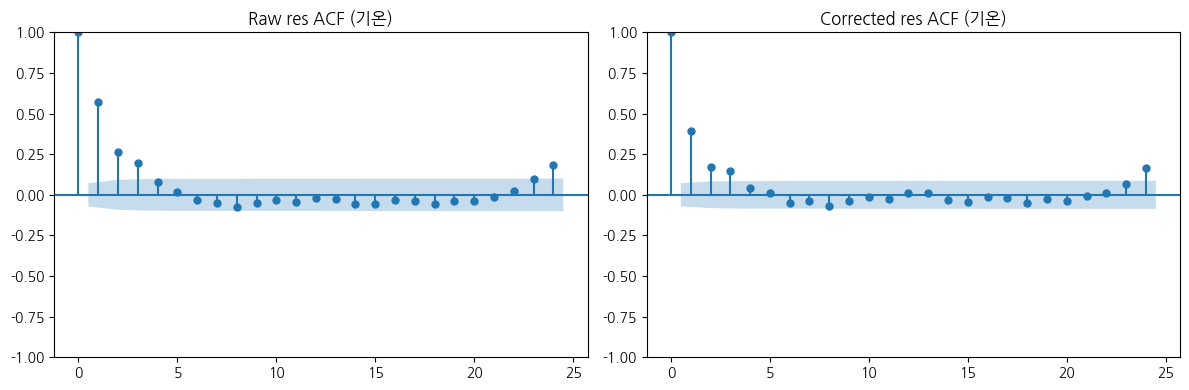

'\n▶ Durbin-Watson statistics\n관측_기온    before DW=0.857, after DW=1.200\n관측_습도    before DW=1.416, after DW=1.502\n관측_대기압   before DW=0.887, after DW=1.403\n'

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch.unitroot import VarianceRatio
from arch.bootstrap import MovingBlockBootstrap
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import ttest_rel
from statsmodels.stats.stattools import medcouple

# 1) 보정 전·후 residual 계산
res_raw = y_val.values - y_val_pred     # (n_samples, 3)
res_cor = y_val.values - y_pred_corrected

# 2) RMSE/MAE Improvement
rmse_raw = np.sqrt(np.mean(res_raw**2, axis=0))
rmse_cor = np.sqrt(np.mean(res_cor**2, axis=0))
mae_raw  = np.mean(np.abs(res_raw), axis=0)
mae_cor  = np.mean(np.abs(res_cor), axis=0)

print("▶ RMSE change:", rmse_raw, "→", rmse_cor, " (Δ=", rmse_cor - rmse_raw, ")")
print("▶ MAE  change:", mae_raw,  "→", mae_cor,  " (Δ=", mae_cor  - mae_raw,  ")\n")

# 3) 통계적 유의성 검사: paired t-test on squared-errors
for i, col in enumerate(obs_cols):
    sqe_raw = res_raw[:, i]**2
    sqe_cor = res_cor[:, i]**2
    tstat, pval = ttest_rel(sqe_raw, sqe_cor)
    print(f"{col:8s} squared-error t-test    t={tstat:.3f}, p={pval:.4f}")

# 4) 잔차 자기상관 검정 (Ljung–Box) before vs after
print("\n▶ Ljung–Box p-values (lag=10)")
for i, col in enumerate(obs_cols):
    lb0 = acorr_ljungbox(res_raw[:, i], lags=[10], return_df=True)["lb_pvalue"].iloc[0]
    lb1 = acorr_ljungbox(res_cor[:, i], lags=[10], return_df=True)["lb_pvalue"].iloc[0]
    print(f"{col:8s} before p={lb0:.4f}, after p={lb1:.4f}")

# 5) Durbin-Watson (autocorrelation at lag1)
print("\n▶ Durbin-Watson statistics")
for i, col in enumerate(obs_cols):
    dw0 = durbin_watson(res_raw[:, i])
    dw1 = durbin_watson(res_cor[:, i])
    print(f"{col:8s} before DW={dw0:.3f}, after DW={dw1:.3f}")

# 6) ACF/PACF 시각화 (예: 기온 residual)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(res_raw[:,0], lags=24, title="Raw res ACF (기온)", ax=plt.gca())
plt.subplot(1,2,2)
plot_acf(res_cor[:,0], lags=24, title="Corrected res ACF (기온)", ax=plt.gca())
plt.tight_layout()
plt.show()


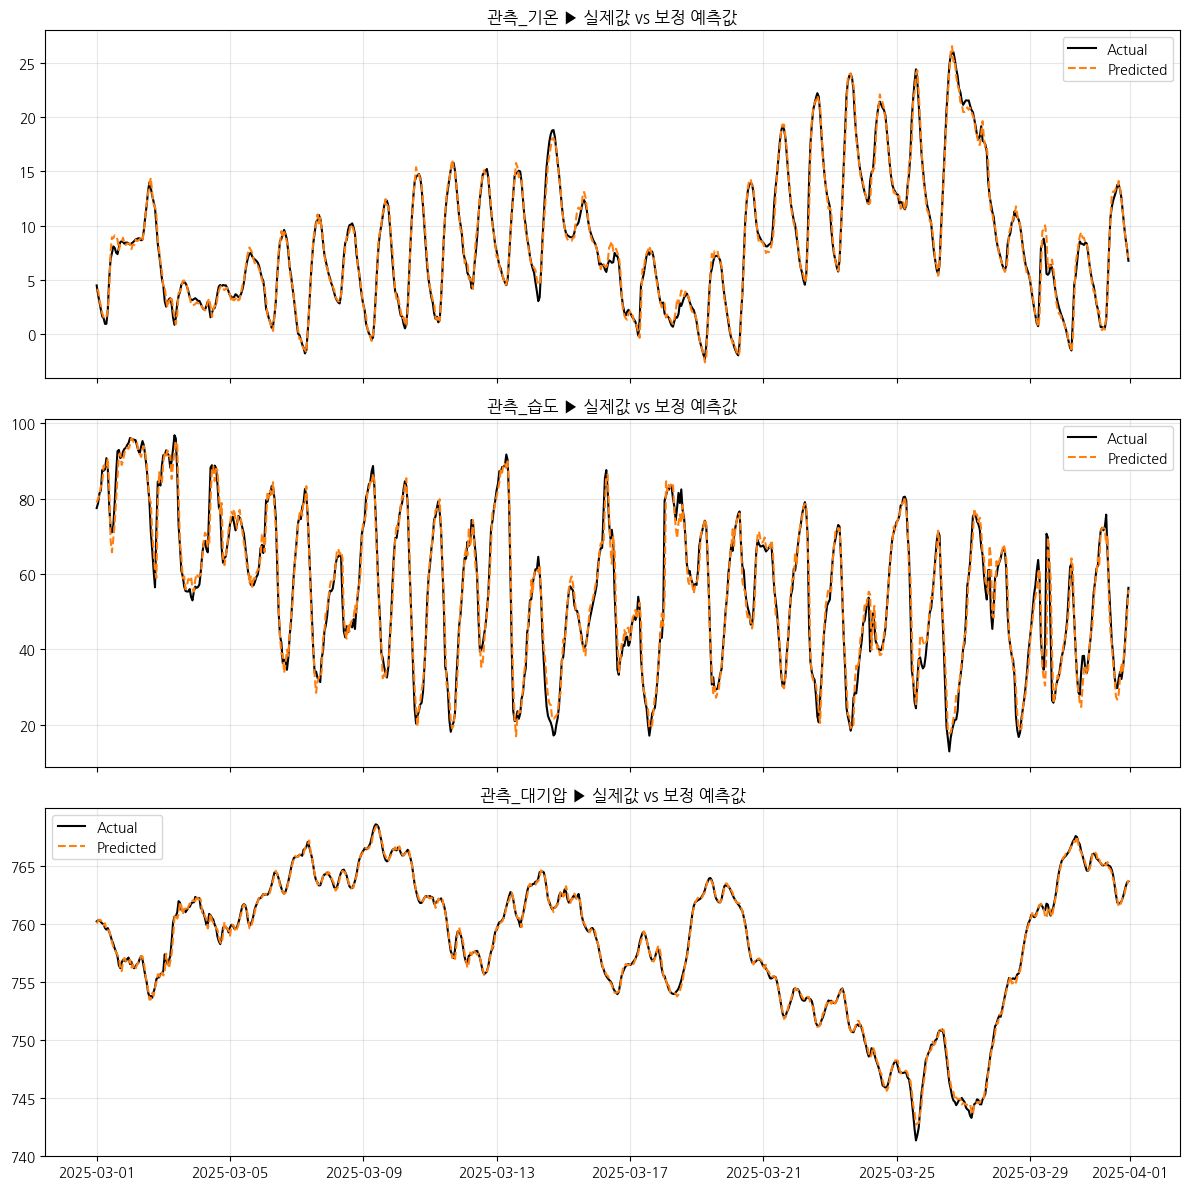

In [ ]:
import matplotlib.pyplot as plt

n_feats = len(obs_cols)
fig, axes = plt.subplots(n_feats, 1, figsize=(12, 4 * n_feats), sharex=True)

if n_feats == 1:
    axes = [axes]

for i, col in enumerate(obs_cols):
    ax = axes[i]
    ax.plot(y_val.index, y_val[col], label='Actual', color='black', linewidth=1.5)
    ax.plot(y_val.index, y_pred_corrected[:, i], label='Predicted', color='tab:orange', linestyle='--')
    ax.set_title(f'{col} ▶ 실제값 vs 보정 예측값')
    ax.grid(alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# 1) 기본 설정 --------------------------------------------------------------------------
n_splits  = 5
random_st = 42
kf        = KFold(n_splits=n_splits, shuffle=True, random_state=random_st)

# 2) 베이스러너 파라미터 정의 ------------------------------------------------------------
lgb_params = {
    'objective'    : 'regression',
    'n_estimators' : 200,
    'learning_rate': 0.05,
    'max_depth'    : 8,
    'random_state' : random_st,
    'n_jobs'       : -1,
    'verbosity'    : -1
}
xgb_params = {
    'objective'    : 'reg:squarederror',
    'n_estimators' : 200,
    'learning_rate': 0.05,
    'max_depth'    : 8,
    'random_state' : random_st,
    'n_jobs'       : -1,
    'verbosity'    : 0
}

# 3) OOF + validation 예측용 배열 준비 ----------------------------------------------------
obs_cols    = ['관측_기온','관측_습도','관측_대기압']
n_targets   = len(obs_cols)
X_tr_full   = X_train.copy()       # 기존에 준비된 train
y_tr_full   = y_train.copy()
X_val_data  = X_val.copy()

n_train     = X_tr_full.shape[0]
n_val       = X_val_data.shape[0]

oof_lgb     = np.zeros((n_train, n_targets))
oof_xgb     = np.zeros((n_train, n_targets))
val_pred_lgb= np.zeros((n_val,   n_targets))
val_pred_xgb= np.zeros((n_val,   n_targets))

# 4) K-Fold Stacking --------------------------------------------------------------------
for fold, (tr_idx, vl_idx) in enumerate(kf.split(X_tr_full)):
    X_tr, X_vl = X_tr_full.iloc[tr_idx], X_tr_full.iloc[vl_idx]
    y_tr, y_vl = y_tr_full.iloc[tr_idx], y_tr_full.iloc[vl_idx]

    # 4-1) LightGBM 베이스러너 ------------------------------------------------------------
    m_lgb = MultiOutputRegressor(LGBMRegressor(**lgb_params))
    m_lgb.fit(X_tr, y_tr)
    oof_lgb[vl_idx]    = m_lgb.predict(X_vl)
    val_pred_lgb      += m_lgb.predict(X_val_data) / n_splits

    # 4-2) XGBoost 베이스러너 ------------------------------------------------------------
    m_xgb = MultiOutputRegressor(XGBRegressor(**xgb_params))
    m_xgb.fit(X_tr, y_tr)
    oof_xgb[vl_idx]    = m_xgb.predict(X_vl)
    val_pred_xgb      += m_xgb.predict(X_val_data) / n_splits

# 5) 메타 피처 생성 ----------------------------------------------------------------------
#  (베이스러너 예측치들을 옆으로 붙여서 메타 모델의 입력으로 사용)
X_meta_train = np.hstack([oof_lgb,    oof_xgb   ])  # shape = (n_train, 6)
X_meta_val   = np.hstack([val_pred_lgb,val_pred_xgb])  # shape = (n_val,   6)

# 6) 메타러너 학습 & 예측 ---------------------------------------------------------------
meta = Ridge(alpha=1.0, random_state=random_st)
meta.fit(X_meta_train, y_tr_full)
y_stack_pred = meta.predict(X_meta_val)   # shape = (n_val, 3)

# 7) 평가 ------------------------------------------------------------------------------
weights = np.array([0.5, 0.3, 0.2])
rmse_stack, mae_stack = [], []

print("=== STACKING Performance ===")
for i, col in enumerate(obs_cols):
    r = np.sqrt(mean_squared_error(y_val[col], y_stack_pred[:, i]))
    m = mean_absolute_error(   y_val[col], y_stack_pred[:, i])
    rmse_stack.append(r)
    mae_stack.append(m)
    print(f"{col:8s} ▶ RMSE: {r:.4f}, MAE: {m:.4f}")

sRMSE = (weights * np.array(rmse_stack)).sum()
sMAE  = (weights * np.array(mae_stack )).sum()
sAErr = (sRMSE + sMAE) / 2
print(f"STACK ▶ sRMSE: {sRMSE:.4f}, sMAE: {sMAE:.4f}, sAError: {sAErr:.4f}")


=== STACKING Performance ===
관측_기온    ▶ RMSE: 0.6187, MAE: 0.4379
관측_습도    ▶ RMSE: 3.5995, MAE: 2.4303
관측_대기압   ▶ RMSE: 0.3249, MAE: 0.2315
STACK ▶ sRMSE: 1.4542, sMAE: 0.9944, sAError: 1.2243


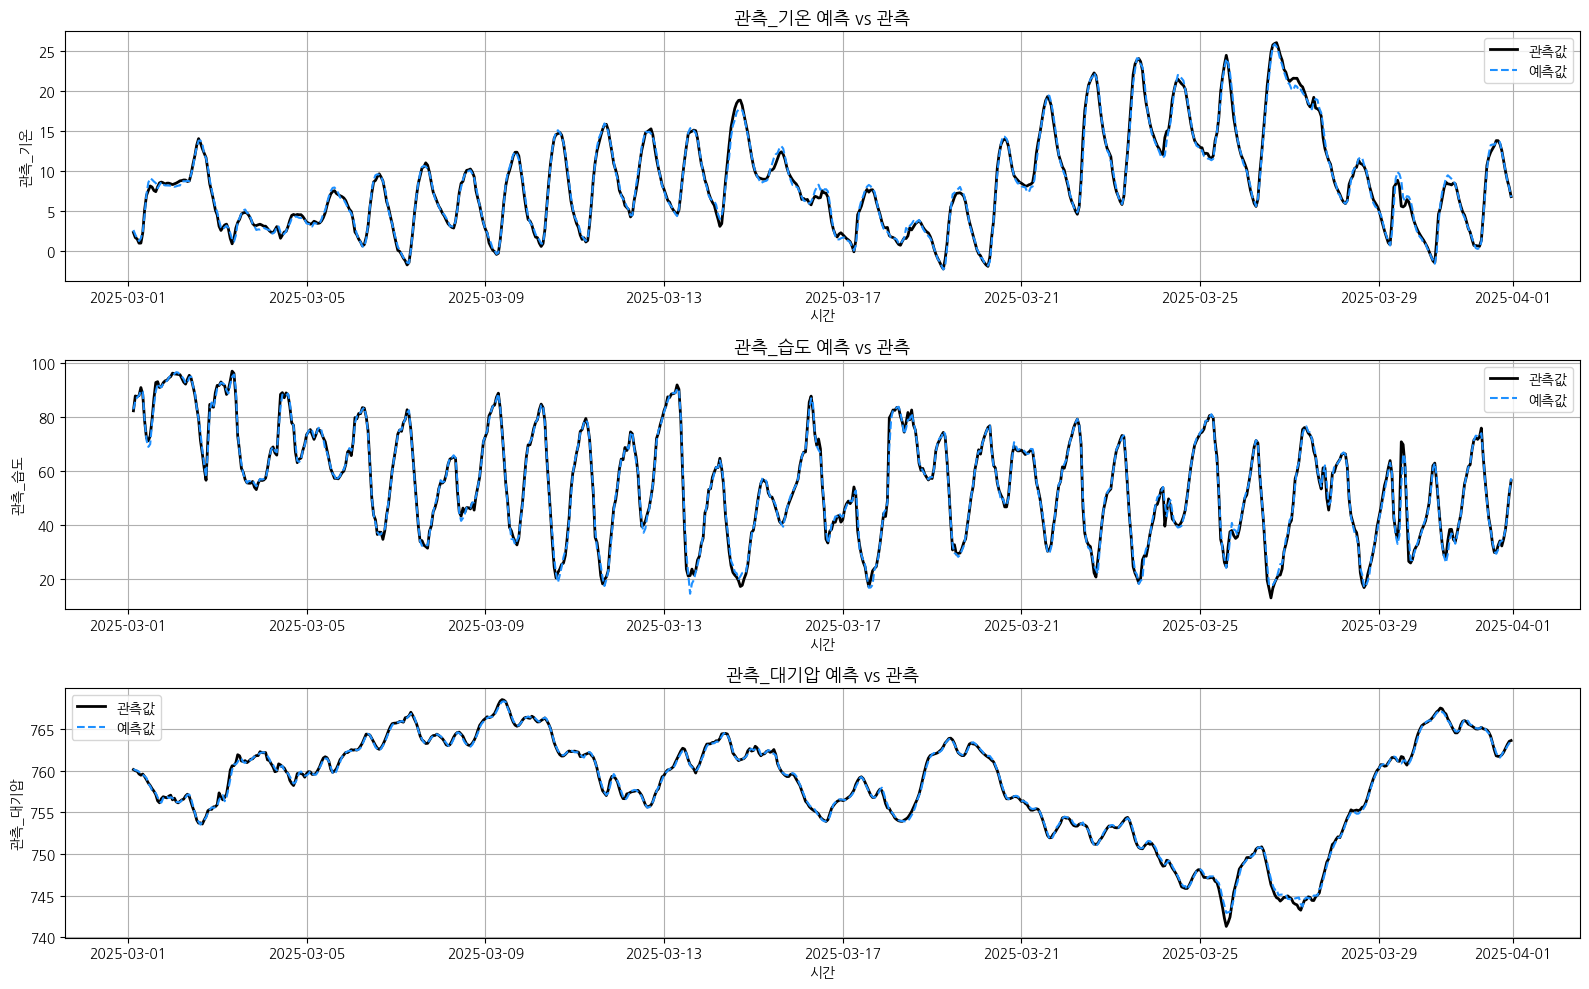

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 예측값을 DataFrame으로 변환
y_pred_df = pd.DataFrame(y_pred, columns=target_cols, index=y_val.index)

# 타깃별 시각화
plt.figure(figsize=(16, 10))

for i, col in enumerate(target_cols, 1):
    plt.subplot(len(target_cols), 1, i)
    plt.plot(y_val.index, y_val[col], label='관측값', color='black', linewidth=2)
    plt.plot(y_pred_df.index, y_pred_df[col], label='예측값', color='dodgerblue', linestyle='--')
    plt.title(f"{col} 예측 vs 관측", fontsize=13)
    plt.xlabel("시간")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


#LSTM

In [ ]:
!pip install

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# 1) 데이터 준비 ---------------------------------------------------
df = df_fill.copy()
df['기상관측일시'] = pd.to_datetime(df['기상관측일시'])
df = df.set_index('기상관측일시').sort_index()

# 타깃/예측 컬럼 정의
target_cols = ['관측_습도','관측_기온','관측_대기압']
pred_cols   = ['예측_일사량','예측_습도','예측_절대습도','예측_기온','예측_대기압']

# 2) 시간 주기성 인코딩 ---------------------------------------------

df['hour_sin']  = np.sin(2*np.pi*df['시']/24)
df['hour_cos']  = np.cos(2*np.pi*df['시']/24)
df['day_sin']   = np.sin(2*np.pi*df['일']/31)
df['day_cos']   = np.cos(2*np.pi*df['일']/31)
df['month_sin'] = np.sin(2*np.pi*df['월']/12)
df['month_cos'] = np.cos(2*np.pi*df['월']/12)
df['is_2025'] = (df.index.year == 2025).astype(int)

# 불필요 컬럼 제거
df.drop(columns=['월','일','시'], inplace=True)
df.dropna(inplace=True)

# 3) 스케일링 --------------------------------------------------------
# input: 예측치 + cyclical;   y: 관측치
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_all = scaler_X.fit_transform(df[pred_cols                                ])
y_all = scaler_y.fit_transform(df[target_cols])

# 4) 시퀀스 윈도우 생성 ---------------------------------------------
def make_sequences(X, y, n_steps):
    Xs, ys = [], []
    for i in range(n_steps, len(X)):
        Xs.append(X[i-n_steps:i, :])
        ys.append(y[i, :])
    return np.array(Xs), np.array(ys)

n_steps = 24   # 과거 24시간 정보 사용
X_seq, y_seq = make_sequences(X_all, y_all, n_steps)

# 5) train/val 분리 (2025-03-01 이후를 val)
time_idx = df.index[n_steps:]
train_mask = time_idx <  pd.to_datetime('2025-03-01')
val_mask   = time_idx >= pd.to_datetime('2025-03-01')

X_train, X_val = X_seq[train_mask], X_seq[val_mask]
y_train, y_val = y_seq[train_mask], y_seq[val_mask]

# 6) LSTM 모델 정의 & 컴파일 ----------------------------------------
model = Sequential([
    LSTM(128, input_shape=(n_steps, X_seq.shape[2]), return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(32),
    BatchNormalization(),
    Dropout(0.2),

    Dense(len(target_cols), activation='linear')
])
model.compile(optimizer='adam', loss='mse')

# 7) 학습 ------------------------------------------------------------
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

# 8) 예측 & 역스케일링 ------------------------------------------------
y_pred_s = model.predict(X_val)
y_pred   = scaler_y.inverse_transform(y_pred_s)
y_true   = scaler_y.inverse_transform(y_val)

# 9) 평가 지표 출력 ----------------------------------------------------
for i, col in enumerate(target_cols):
    rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    mae  = mean_absolute_error(y_true[:, i], y_pred[:, i])
    print(f"{col:8s} ▶ RMSE: {rmse:.3f}, MAE: {mae:.3f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
318/318 - 22s - 71ms/step - loss: 0.3990 - val_loss: 0.0363
Epoch 2/100
318/318 - 20s - 63ms/step - loss: 0.1031 - val_loss: 0.0120
Epoch 3/100
318/318 - 20s - 63ms/step - loss: 0.0443 - val_loss: 0.0094
Epoch 4/100
318/318 - 16s - 49ms/step - loss: 0.0241 - val_loss: 0.0096
Epoch 5/100
318/318 - 16s - 49ms/step - loss: 0.0165 - val_loss: 0.0084
Epoch 6/100
318/318 - 20s - 64ms/step - loss: 0.0130 - val_loss: 0.0092
Epoch 7/100
318/318 - 22s - 68ms/step - loss: 0.0106 - val_loss: 0.0096
Epoch 8/100
318/318 - 20s - 62ms/step - loss: 0.0093 - val_loss: 0.0082
Epoch 9/100
318/318 - 21s - 65ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 10/100
318/318 - 20s - 63ms/step - loss: 0.0084 - val_loss: 0.0094
Epoch 11/100
318/318 - 15s - 48ms/step - loss: 0.0081 - val_loss: 0.0086
Epoch 12/100
318/318 - 22s - 68ms/step - loss: 0.0078 - val_loss: 0.0090
Epoch 13/100
318/318 - 20s - 62ms/step - loss: 0.0077 - val_loss: 0.0087
Epoch 14/100
318/318 - 21s - 66ms/step - loss: 0.0074 - val_

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# 1) 데이터 준비 ---------------------------------------------------
df = df_fill.copy()
df['기상관측일시'] = pd.to_datetime(df['기상관측일시'])
df = df.set_index('기상관측일시').sort_index()

# 관측값, 예측값 컬럼
obs_cols  = ['관측_습도','관측_기온','관측_대기압']
pred_cols = ['예측_일사량','예측_습도','예측_절대습도','예측_기온','예측_대기압']

# 2) 잔차(오차) 컬럼 생성
for c in obs_cols:
    pred_c = c.replace('관측','예측')
    df[f'{c}_res'] = df[c] - df[pred_c]

# 3) 시간 순환 인코딩
df['hour_sin']  = np.sin(2*np.pi*df['시']/24)
df['hour_cos']  = np.cos(2*np.pi*df['시']/24)
df['day_sin']   = np.sin(2*np.pi*df['일']/31)
df['day_cos']   = np.cos(2*np.pi*df['일']/31)
df['month_sin'] = np.sin(2*np.pi*df['월']/12)
df['month_cos'] = np.cos(2*np.pi*df['월']/12)

# 불필요 컬럼 제거 & 결측 드롭
df.drop(columns=['월','일','시'], inplace=True)
df.dropna(inplace=True)

# 4) 스케일링 --------------------------------------------------------
# X: 예측값 + 시간 인코딩
X_cols = pred_cols + ['hour_sin','hour_cos','day_sin','day_cos','month_sin','month_cos']
# y: 잔차 3개
y_cols = [f'{c}_res' for c in obs_cols]

scaler_X = MinMaxScaler().fit(df[X_cols])
scaler_y = MinMaxScaler().fit(df[y_cols])

X_all = scaler_X.transform(df[X_cols])
y_all = scaler_y.transform(df[y_cols])

# 5) 시퀀스 윈도잉 ---------------------------------------------------
def make_sequences(X, y, n_steps):
    Xs, ys = [], []
    for i in range(n_steps, len(X)):
        Xs.append(X[i-n_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

n_steps = 24
X_seq, y_seq = make_sequences(X_all, y_all, n_steps)

# 6) train/val split (2025-03-01 기준) ------------------------------
time_idx = df.index[n_steps:]
mask_train = time_idx <  pd.to_datetime('2025-03-01')
mask_val   = time_idx >= pd.to_datetime('2025-03-01')

X_train, X_val = X_seq[mask_train], X_seq[mask_val]
y_train, y_val = y_seq[mask_train], y_seq[mask_val]

print("Train / Val samples:", len(X_train), len(X_val))

# 7) LSTM 모델 정의 & 학습 --------------------------------------------
model = Sequential([
    LSTM(64, input_shape=(n_steps, X_seq.shape[2]), return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),

    LSTM(32),
    BatchNormalization(),
    Dropout(0.2),

    Dense(len(y_cols), activation='linear')
])
model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, batch_size=32,
    callbacks=[es], verbose=2
)

# 8) 예측 & 보정값 계산 -----------------------------------------------
# LSTM이 예측한 잔차
y_pred_res_s = model.predict(X_val)
# 원단위 잔차로 역변환
y_pred_res = scaler_y.inverse_transform(y_pred_res_s)
y_true_res = scaler_y.inverse_transform(y_val)

# 보정 후 예측값 = 원 예보값 + 예측 잔차
# val 구간의 원 예보값
pred_val = df[X_cols].iloc[n_steps:][mask_val][pred_cols].values
corrected = pred_val.copy()
for i, c in enumerate(obs_cols):
    corrected[:, i] = pred_val[:, pred_cols.index(c.replace('관측','예측'))] + y_pred_res[:, i]

# 9) 평가 ------------------------------------------------------------
# 실제 관측값
true_val = df[obs_cols].iloc[n_steps:][mask_val].values

for i, c in enumerate(obs_cols):
    rmse_raw = np.sqrt(mean_squared_error(true_val[:, i], pred_val[:, pred_cols.index(c.replace('관측','예측'))]))
    mae_raw  = mean_absolute_error(true_val[:, i], pred_val[:, pred_cols.index(c.replace('관측','예측'))])
    rmse_cor = np.sqrt(mean_squared_error(true_val[:, i], corrected[:, i]))
    mae_cor  = mean_absolute_error(true_val[:, i], corrected[:, i])
    print(f"{c:8s} ▶ Raw RMSE: {rmse_raw:.3f}, MAE: {mae_raw:.3f}  |  " +
          f"Corrected RMSE: {rmse_cor:.3f}, MAE: {mae_cor:.3f}")


Train / Val samples: 10176 744


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
318/318 - 21s - 66ms/step - loss: 0.4025 - val_loss: 0.0162
Epoch 2/50
318/318 - 6s - 19ms/step - loss: 0.0990 - val_loss: 0.0166
Epoch 3/50
318/318 - 12s - 37ms/step - loss: 0.0393 - val_loss: 0.0126
Epoch 4/50
318/318 - 6s - 20ms/step - loss: 0.0202 - val_loss: 0.0123
Epoch 5/50
318/318 - 7s - 22ms/step - loss: 0.0131 - val_loss: 0.0119
Epoch 6/50
318/318 - 6s - 19ms/step - loss: 0.0107 - val_loss: 0.0119
Epoch 7/50
318/318 - 7s - 22ms/step - loss: 0.0094 - val_loss: 0.0121
Epoch 8/50
318/318 - 6s - 18ms/step - loss: 0.0088 - val_loss: 0.0126
Epoch 9/50
318/318 - 7s - 23ms/step - loss: 0.0085 - val_loss: 0.0115
Epoch 10/50
318/318 - 10s - 31ms/step - loss: 0.0082 - val_loss: 0.0120
Epoch 11/50
318/318 - 6s - 19ms/step - loss: 0.0080 - val_loss: 0.0118
Epoch 12/50
318/318 - 11s - 36ms/step - loss: 0.0080 - val_loss: 0.0118
Epoch 13/50
318/318 - 10s - 32ms/step - loss: 0.0078 - val_loss: 0.0119
Epoch 14/50
318/318 - 9s - 29ms/step - loss: 0.0077 - val_loss: 0.0117
24/24 ━━━━

#Inference

In [6]:
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 0) 설정 ---------------------------------------------------------------
max_lag   = 3
ma_window = 3

observed_features = ['관측_기온','관측_습도','관측_대기압']
time_features     = [
    'hour_sin','hour_cos',
    'day_sin','day_cos',
    'month_sin','month_cos',
    'is_2025'
]

# 1) 원본 df 준비 & 시계열 인덱스 ------------------------------------------------
df = df_fill.copy()
df['기상관측일시'] = pd.to_datetime(df['기상관측일시'])
df = df.sort_values('기상관측일시') \
       .set_index('기상관측일시')

# 시간주기 인코딩
df['hour_sin']  = np.sin(2*np.pi*df['시']/24)
df['hour_cos']  = np.cos(2*np.pi*df['시']/24)
df['day_sin']   = np.sin(2*np.pi*df['일']/12)
df['day_cos']   = np.cos(2*np.pi*df['일']/12)
df['month_sin'] = np.sin(2*np.pi*df['월']/12)
df['month_cos'] = np.cos(2*np.pi*df['월']/12)

# 2025 플래그
df['is_2025'] = (df.index.year == 2025).astype(int)

# 불필요 컬럼 제거
df = df.drop(columns=['시','일','월'])

# 2) train/val split --------------------------------------------------
train = df[:'2025-02-28 23:00:00']
val   = df['2025-03-01':'2025-03-31 23:00:00']

X_train = train[time_features].copy()
y_train = train[observed_features].copy()
X_val   = val[time_features].copy()
y_val   = val[observed_features].copy()

# 3) lag & MA 피처 생성 (train/val 각각) ----------------------------------
def make_lag_ma(X, Y):
    X = X.copy()
    for feat in observed_features:
        # lag
        for lag in range(1, max_lag+1):
            X[f'{feat}_lag{lag}'] = Y[feat].shift(lag)
        # moving average (과거 ma_window 시점까지)

        X[f'{feat}_ma{ma_window}'] = (
            Y[feat]
            .shift(1)
            .rolling(window=ma_window, min_periods=1)
            .mean()
        )
    return X

X_train = make_lag_ma(X_train, y_train)
X_val   = make_lag_ma(X_val,   y_val)

# 공통된 피처 리스트
feature_cols = X_train.columns.tolist()

# 4) NaN 제거 ------------------------------------------------------------
train_mask = X_train.isna().any(axis=1) | y_train.isna().any(axis=1)
X_train, y_train = X_train.loc[~train_mask], y_train.loc[~train_mask]

val_mask = X_val.isna().any(axis=1) | y_val.isna().any(axis=1)
X_val, y_val     = X_val.loc[~val_mask],     y_val.loc[~val_mask]

# 5) 모델 학습 ----------------------------------------------------------
lgbm = LGBMRegressor(
    objective     = 'regression',
    n_estimators  = 200,
    learning_rate = 0.05,
    max_depth     = 8,
    random_state  = 42,
    n_jobs        = -1,
    verbose = -1
)
model = MultiOutputRegressor(lgbm)
model.fit(X_train, y_train)

# 6) 검증 예측 & 평가 ----------------------------------------------------
y_pred = model.predict(X_val)

rmse_list, mae_list = [], []
for i, col in enumerate(observed_features):
    rmse = np.sqrt(mean_squared_error(y_val[col], y_pred[:, i]))
    mae  = mean_absolute_error(y_val[col], y_pred[:, i])
    rmse_list.append(rmse)
    mae_list.append(mae)
    print(f"{col:8s} ▶ RMSE: {rmse:.3f}, MAE: {mae:.3f}")

# 7) Recursive Forecasting ---------------------------------------------
# test_index: 관측 없는 3월 한 달
test_index = pd.date_range('2025-03-01','2025-03-31 23:00',freq='H')

# full_obs: 과거(2월까지) 관측 + 이후 예측 저장용
full_index = y_train.index.union(test_index)

full_obs = pd.DataFrame(index=full_index, columns=observed_features)
# ✅ 여기서 train.index 가 아니라 y_train.index 로 채워야 행 개수가 맞음
full_obs.loc[y_train.index, observed_features] = y_train.values
# df_pred: 예측 시 입력할 피처를 담을 빈 DataFrame

df_pred = pd.DataFrame(index=test_index, columns=feature_cols)
df_pred[time_features] = df.loc[test_index, time_features]

y_preds = []
for ts in test_index:
    # lag & ma 채우기
    for feat in observed_features:
        for lag in range(1, max_lag+1):
            df_pred.at[ts, f'{feat}_lag{lag}'] = full_obs[feat].shift(lag).loc[ts]
        df_pred.at[ts, f'{feat}_ma{ma_window}'] = (
            full_obs[feat]
            .shift(1)
            .rolling(ma_window, min_periods=1)
            .mean()
            .loc[ts]
        )

    # 예측
    x = df_pred.loc[ts, feature_cols].values.reshape(1, -1)
    y_hat = model.predict(x)[0]
    y_preds.append(y_hat)

    # full_obs 업데이트
    full_obs.loc[ts, observed_features] = y_hat

# 8) 결과 ---------------------------------------------------------------
y_pred_df = pd.DataFrame(
    y_preds,
    index=test_index,
    columns=observed_features
)
print(y_pred_df.head())


관측_기온    ▶ RMSE: 0.662, MAE: 0.464
관측_습도    ▶ RMSE: 3.789, MAE: 2.574
관측_대기압   ▶ RMSE: 0.316, MAE: 0.232
                        관측_기온      관측_습도      관측_대기압
2025-03-01 00:00:00  3.951247  78.457819  760.064251
2025-03-01 01:00:00  3.419102  80.691184  759.971591
2025-03-01 02:00:00  3.043090  81.543395  759.933898
2025-03-01 03:00:00  2.855225  82.279085  759.762298
2025-03-01 04:00:00  2.680771  83.994309  759.674837


In [8]:
import numpy as np

# 가중치 정의 (관측_습도, 관측_대기압, 관측_기온 순서)
weights = np.array([0.5, 0.3, 0.2])

# 결과 저장용 리스트
rmse_list = []
mae_list  = []

# 타깃별 RMSE 및 MAE 계산
for i, col in enumerate(observed_features):
    mse_i = mean_squared_error(y_val[col], y_pred[:, i])
    rmse_i = np.sqrt(mse_i)
    mae_i  = mean_absolute_error(y_val[col], y_pred[:, i])

    rmse_list.append(rmse_i)
    mae_list.append(mae_i)

    print(f"{col:8s} ▶ RMSE: {rmse_i:.3f}, MAE: {mae_i:.3f}")

# 가중 평균 계산
rmse_array = np.array(rmse_list)
mae_array  = np.array(mae_list)

sRMSE = np.sum(weights * rmse_array)
sMAE  = np.sum(weights * mae_array)
sAError = (sRMSE + sMAE) / 2

# 최종 출력
print("\n📊 종합 성능 지표")
print(f"sRMSE   = {sRMSE:.4f}")
print(f"sMAE    = {sMAE:.4f}")
print(f"sAError = {sAError:.4f}")


관측_기온    ▶ RMSE: 0.662, MAE: 0.464
관측_습도    ▶ RMSE: 3.789, MAE: 2.574
관측_대기압   ▶ RMSE: 0.316, MAE: 0.232

📊 종합 성능 지표
sRMSE   = 1.5309
sMAE    = 1.0507
sAError = 1.2908


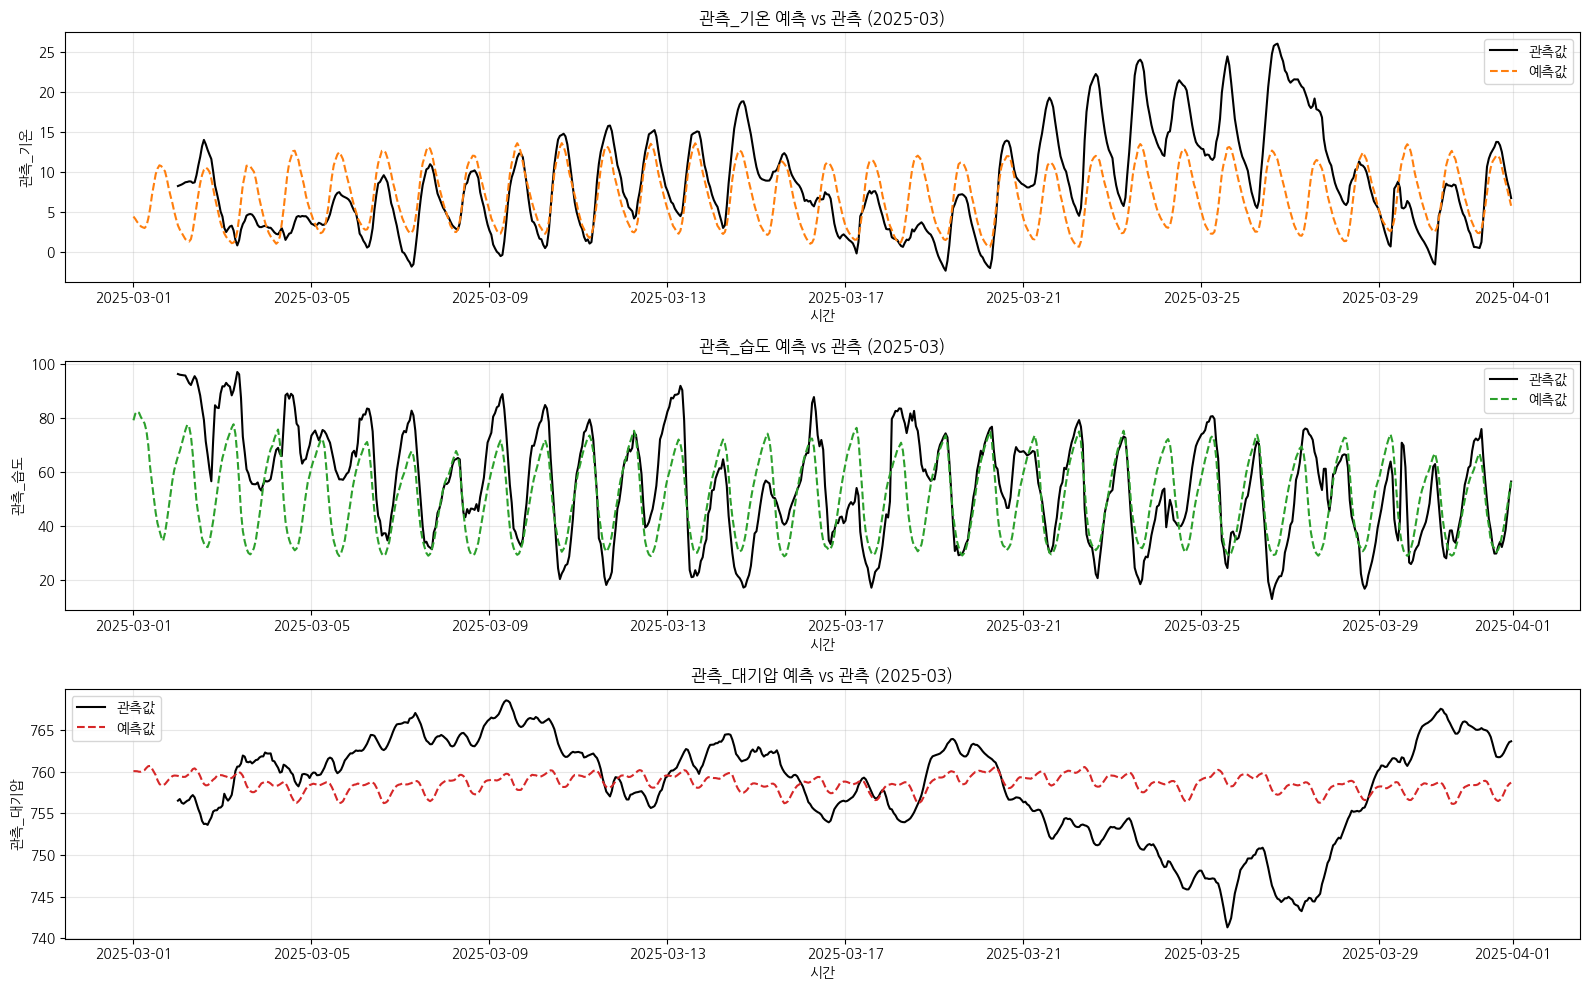

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# ─── 1) 실제값(y_true)과 예측값(y_pred_df) 준비 ────────────────────────
# y_val: val 분리 시점(3월) 실제 관측  DataFrame (index=DatetimeIndex, cols=관측_*)
# y_pred_df: 위 순차 예측 루프 결과 DataFrame (index=DatetimeIndex, cols=관측_*)

# (만약 y_pred_df 가 recursive 예측용, y_val 이 기존 검증용이라면,
#  범위도 test_index 로 맞맞춰 주시면 됩니다.)
start, end = '2025-03-01', '2025-03-31 23:00'
y_true = y_val.loc[start:end]
y_pred = y_pred_df.loc[start:end]

# ─── 2) 플롯 설정 ──────────────────────────────────────────────────────
plt.figure(figsize=(16, 10))
for i, col in enumerate(y_true.columns, 1):
    plt.subplot(len(y_true.columns), 1, i)
    plt.plot(y_true.index, y_true[col], label='관측값', color='black', lw=1.5)
    plt.plot(y_pred.index, y_pred[col], label='예측값', color='C{}'.format(i), ls='--')
    plt.title(f'{col} 예측 vs 관측 (2025-03)', fontsize=12)
    plt.xlabel('시간')
    plt.ylabel(col)
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


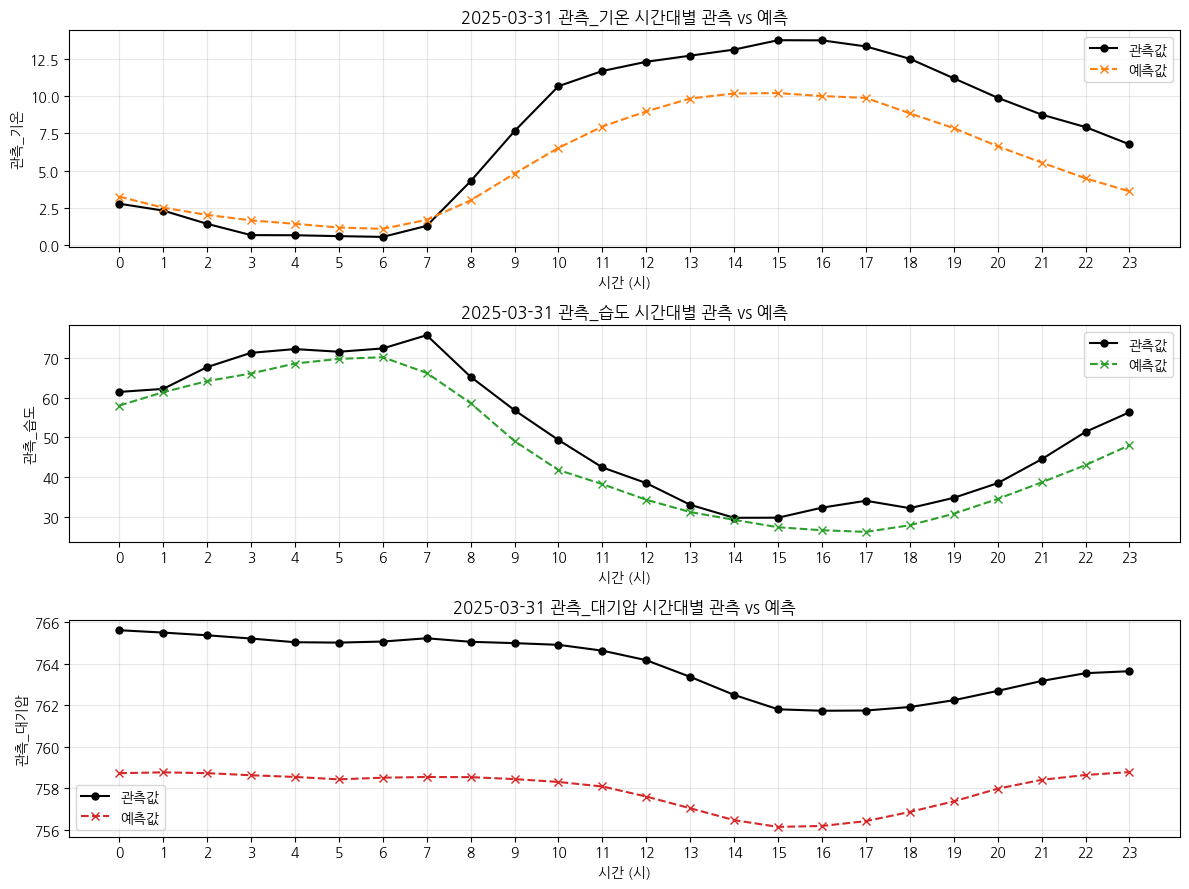

In [ ]:
import matplotlib.pyplot as plt

# 1) 날짜 지정 및 데이터 슬라이싱
date = '2025-03-31'
true_day = y_val.loc[date]
pred_day = y_pred_df.loc[date]

# 2) 피처 리스트 (원하시는 순서대로 조정 가능)
features = ['관측_기온', '관측_습도', '관측_대기압']

# 3) 시각화
plt.figure(figsize=(12, 9))
for i, col in enumerate(features, 1):
    plt.subplot(len(features), 1, i)
    plt.plot(true_day.index.hour, true_day[col],
             'o-', label='관측값', color='black', markersize=5)
    plt.plot(pred_day.index.hour, pred_day[col],
             'x--', label='예측값', color=f'C{i}', markersize=6)
    plt.title(f'{date} {col} 시간대별 관측 vs 예측', fontsize=12)
    plt.xlabel('시간 (시)')
    plt.ylabel(col)
    plt.xticks(range(0, 24))
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
